![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)"

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

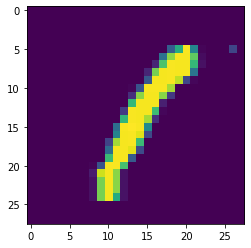

tensor(5)


In [6]:
import matplotlib.pyplot as plt
onesones = X_train[y_train == 1]
plt.imshow(onesones[80, :, :])
plt.show()
print(y_train[0])

In [7]:
onesones[0].min(), onesones[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [8]:
y_test[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [9]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [10]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [11]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [13]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [14]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

n_epochs = 10000
for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    train_preds = lenet5.forward(X_test)

    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(f'epoch {epoch}/{n_epochs}: accuracy: {accuracy}, test_loss = {test_loss_history[-1]}')

epoch 0/10000: accuracy: 0.9764999747276306, test_loss = 0.07756675779819489
epoch 1/10000: accuracy: 0.982699990272522, test_loss = 0.05257202684879303
epoch 2/10000: accuracy: 0.9864999651908875, test_loss = 0.041180677711963654
epoch 3/10000: accuracy: 0.9858999848365784, test_loss = 0.04158869385719299
epoch 4/10000: accuracy: 0.9881999492645264, test_loss = 0.037453193217515945
epoch 5/10000: accuracy: 0.9879999756813049, test_loss = 0.037995535880327225
epoch 6/10000: accuracy: 0.9866999983787537, test_loss = 0.04184694215655327
epoch 7/10000: accuracy: 0.9881999492645264, test_loss = 0.03746705502271652
epoch 8/10000: accuracy: 0.9855999946594238, test_loss = 0.04678317531943321
epoch 9/10000: accuracy: 0.9882999658584595, test_loss = 0.0396193228662014
epoch 10/10000: accuracy: 0.9866999983787537, test_loss = 0.043775442987680435
epoch 11/10000: accuracy: 0.9884999990463257, test_loss = 0.037393033504486084
epoch 12/10000: accuracy: 0.9883999824523926, test_loss = 0.04059711843

RuntimeError: CUDA out of memory. Tried to allocate 180.00 MiB (GPU 0; 1.96 GiB total capacity; 830.89 MiB already allocated; 7.00 MiB free; 1.26 GiB reserved in total by PyTorch)

In [15]:
lenet5.forward(X_test)

RuntimeError: CUDA out of memory. Tried to allocate 180.00 MiB (GPU 0; 1.96 GiB total capacity; 830.89 MiB already allocated; 7.00 MiB free; 1.26 GiB reserved in total by PyTorch)

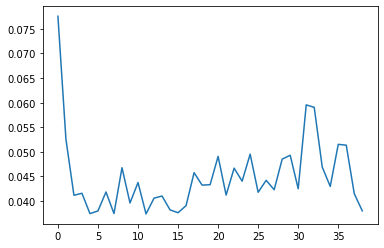

In [16]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);